# Project
# Analysing the effect of Market News Sentiment on Stock Price Prediction.

# Step 1: Data Extraction

* Extracting the tweets about Reliance company posted by news forums on Twitter from 1st January 2011 to 1st January 2023.
* The package used to scrape the tweets from Twitter is called "snscrape".
  * There are 15575 observations in tweet data
* The data about Stock prices of Reliance Industries Limited is collected from Yahoo Finance website.
  * There are 1225 observations in stock data

## Installing the required package

In [ ]:
!pip install snscrape -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install vaderSentiment -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_addons -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 12.4 MB/s eta 0:00:00


In [ ]:
!pip install advertools -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.4/286.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 10.3 MB/s eta 0:00:00


## Loading the required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import snscrape.modules.twitter as sntwtr
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras import regularizers
from tensorflow_addons.metrics.r_square import RSquare
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (16, 8)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Scraping the tweets

In [ ]:
# query='''from:@EconomicTimes OR from:@DeccanHerald OR from:@CNNnews18 OR
# from:@indiatvnews OR from:@ndtv OR from:@LiveLawIndia OR from:@IndiaToday OR
# from:@IndianExpress OR from:@ReutersIndia OR from:@FoxBusiness OR
# from:@the_hindu OR from:@livemint OR from:@moneycontrol OR from:@bsindia OR
# from:@business OR from:@forbes_india OR from:@qz OR from:@bqprime OR
# from:@Investingcom Reliance OR Jio OR RIL
# lang:en since:2018-01-01 until:2023-01-01'''
# tweets=[]
# limit=150000

# for tweet in sntwtr.TwitterSearchScraper(query).get_items():
#   if len(tweets) == limit:
#         break
#   else:
#       tweets.append([tweet.date, tweet.username, tweet.content])

In [ ]:
# tweet_df = pd.DataFrame(tweets, columns=['DateTime', 'User', 'Tweet'])

In [ ]:
tweet_path='/content/drive/MyDrive/Colab Notebooks/Project/T5y_reliance.csv'
# tweet_df.to_csv(tweet_path,index=False)

# Loading the stock data

In [ ]:
stock_path='/content/drive/MyDrive/Colab Notebooks/Project/T5y_RELIANCE_NS.csv'
stock_df=pd.read_csv(stock_path)

In [ ]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,914.035828,914.035828,898.978577,901.207458,881.918274,4362651
1,2018-01-02,904.426941,910.915405,897.888916,902.594299,883.275391,4383980
2,2018-01-03,916.314270,917.304871,904.476440,906.210022,886.813721,6233847
3,2018-01-04,909.528564,913.144287,907.101563,911.658386,892.145386,4157621
4,2018-01-05,913.144287,918.196411,911.608887,914.580688,895.005188,3434151


# Pre-processing the tweets

In [ ]:
tweet_df=pd.read_csv(tweet_path)

In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15575 entries, 0 to 15574
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  15575 non-null  object
 1   User      15575 non-null  object
 2   Tweet     15575 non-null  object
dtypes: object(3)
memory usage: 365.2+ KB


In [ ]:
tweet_df.describe()

,DateTime,User,Tweet
count,15575,15575,15575
unique,15502,16,15440
top,2018-10-30 05:45:02+00:00,bqprime,"Reliance Industries' valuation tanked ₹42,994...."
freq,3,3901,5


In [ ]:
tweet_df.isnull().sum()

DateTime    0
User        0
Tweet       0
dtype: int64

In [ ]:
tweet_df.duplicated().sum()

1

In [ ]:
tweet_df.drop_duplicates(inplace=True)

In [ ]:
tweet_data=tweet_df.copy()

In [ ]:
tweet_df['Date']=pd.to_datetime(tweet_df['DateTime']).dt.date

In [ ]:
tweet_df.drop(['DateTime','User'],axis=1,inplace=True)

In [ ]:
tweet_df=tweet_df[['Date','Tweet']]

In [ ]:
def preprocess(text):
  link_text=re.sub(r'http\S+','',text)
  at_text=re.sub("@[A-Za-z0-9_]+","",link_text)
  hash_text=re.sub("#[A-Za-z0-9_]+","",at_text)
  n_text=re.sub("[\n]","",hash_text)
  l_text=re.sub("[|]","",n_text)
  return l_text

In [ ]:
tweet_df['Tweet']=tweet_df['Tweet'].apply(preprocess)

# Applying VADER sentiment Intensity analyzer

In [ ]:
def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']

In [ ]:
tweet_df['Score']=tweet_df['Tweet'].apply(sentiment_scores)

In [ ]:
def label(score):
  if score>0:
    return 'POS'
  elif score<0:
    return 'NEG'
  else:
    return 'NEU'

In [ ]:
tweet_df['Polarity']=tweet_df['Score'].apply(label)

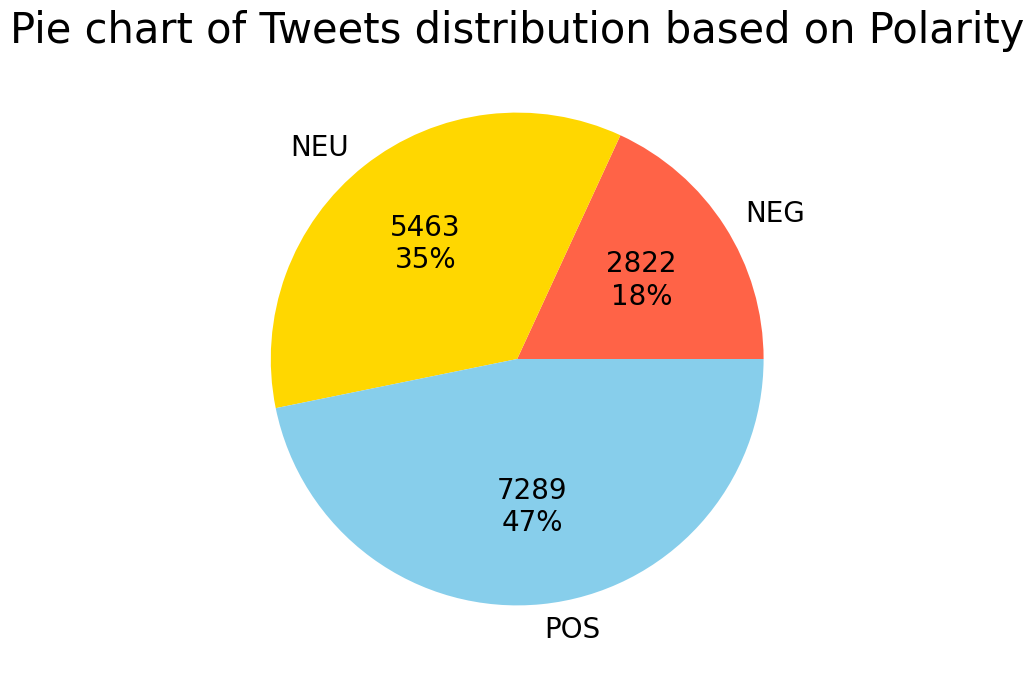

In [ ]:
def label_function(val):
    return f'{val / 100 * len(tweet_df):.0f}\n{val:.0f}%'
tweet_df.groupby('Polarity').size().plot(kind='pie', autopct=label_function,
                                  textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.title('Pie chart of Tweets distribution based on Polarity',fontsize=30)
plt.ylabel('')
plt.show()

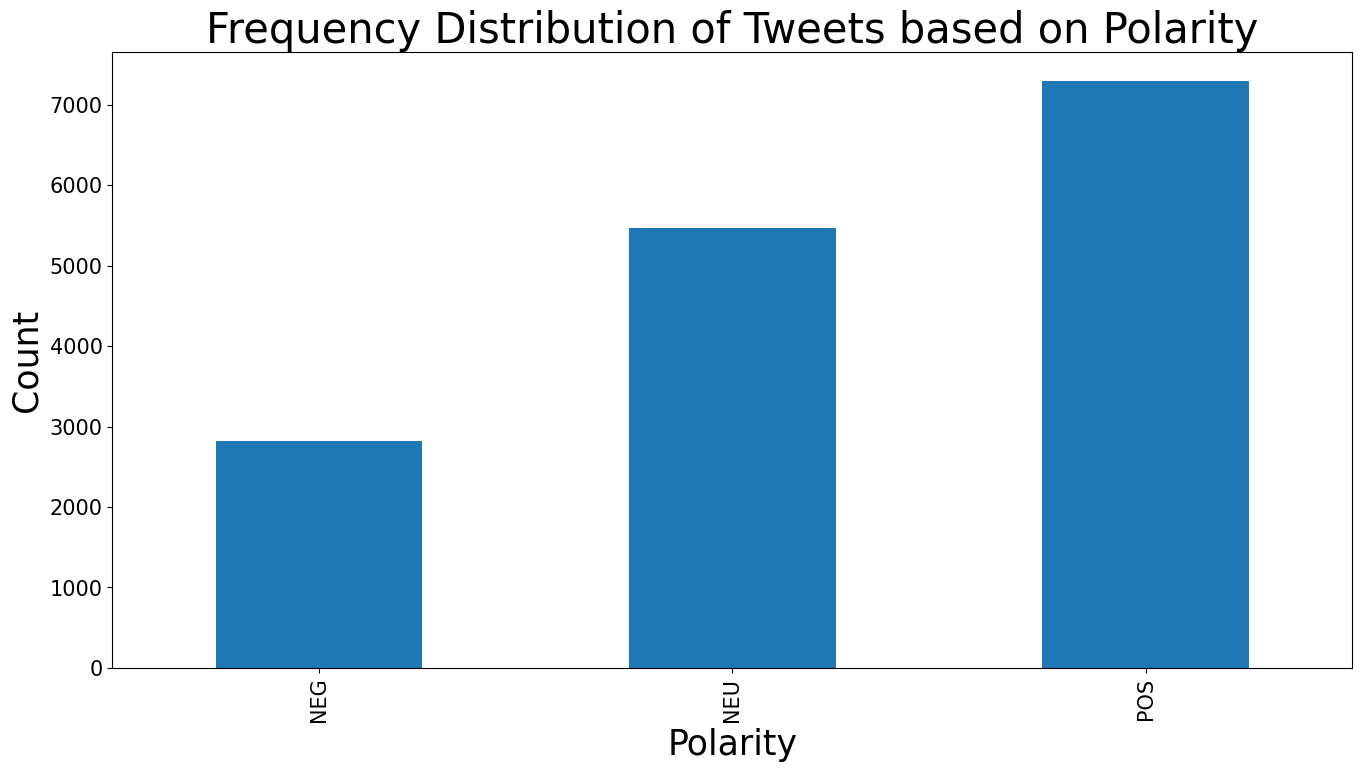

In [ ]:
tweet_df.groupby('Polarity').size().plot(kind='bar')
plt.title('Frequency Distribution of Tweets based on Polarity',fontsize=30)
plt.ylabel('Count',fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Polarity',fontsize=25)
plt.show()

In [ ]:
pos_tweet=tweet_df.query('Polarity=="POS"')['Tweet']
neg_tweet=tweet_df.query('Polarity=="NEG"')['Tweet']
neu_tweet=tweet_df.query('Polarity=="NEU"')['Tweet']

In [ ]:
import wordcloud
import advertools as adv
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
sw=['Reliance Industries', 'RIL', 'Reliance','Jio','Mukesh Ambani',
    'Reliance Retail','Industries','Mukesh','Ambani','India','Read','said',
    'report','S','Ltd','Limited','Rs','crore','amp']
stopwords=set(adv.stopwords['english'])
for i in sw:
  stopwords.add(i)

def show(column,title):
  text=' '.join(column.astype(str).tolist())
  fig_wordcloud=WordCloud(stopwords=stopwords,
                          background_color='black',
                          colormap='viridis',width=800,
                          height=600).generate(text)
  plt.figure(figsize=(10,7),frameon=True)
  plt.imshow(fig_wordcloud)
  plt.axis('off')
  plt.title(title,fontsize=20)
  plt.show()

# Visualization of tweets based on their label

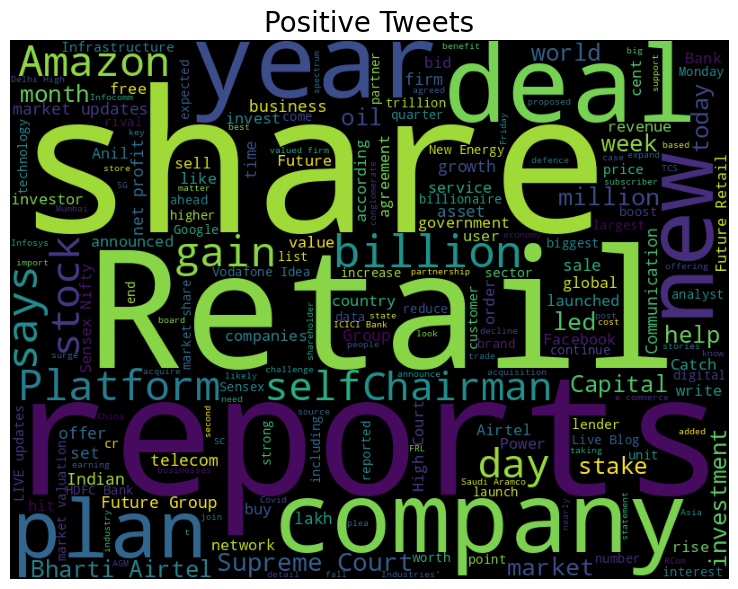

In [ ]:
show(pos_tweet,'Positive Tweets')

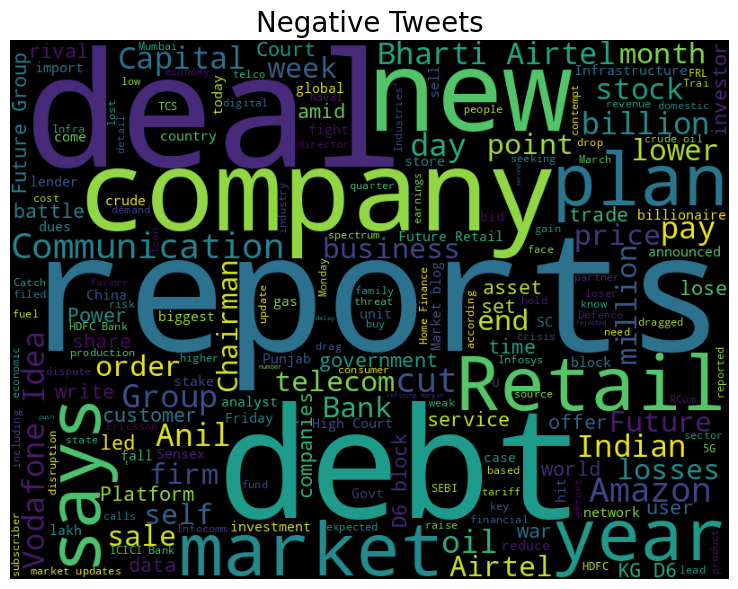

In [ ]:
show(neg_tweet,'Negative Tweets')

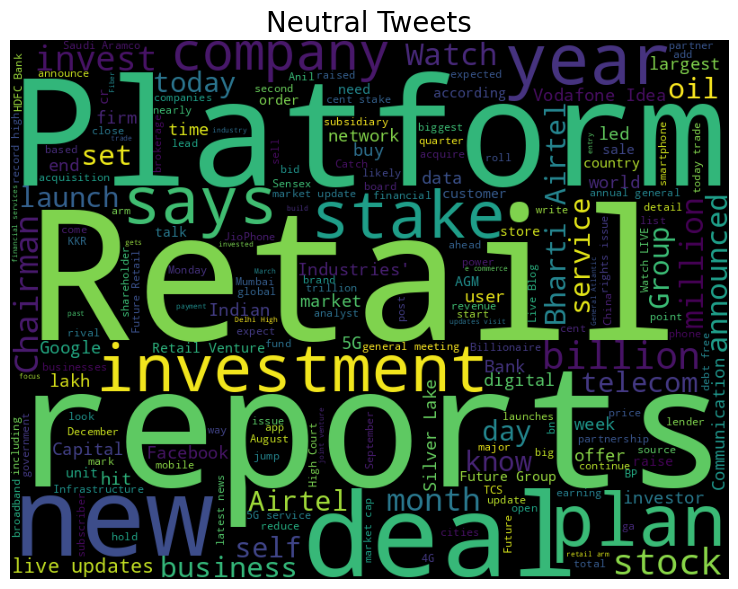

In [ ]:
show(neu_tweet,'Neutral Tweets')

In [ ]:
tweet_score_df=pd.DataFrame(tweet_df.groupby([tweet_df['Date']]).mean())

In [ ]:
def Sentiment(score):
  if score>0:
    return 2
  elif score<0:
    return 0
  else:
    return 1

In [ ]:
tweet_score_df['Sentiment']=tweet_score_df['Score'].apply(Sentiment)
tweet_score_df.head()

,Score,Sentiment
Date,,
2018-01-01,0.298733,2
2018-01-02,0.301140,2
2018-01-03,-0.036662,0
2018-01-04,-0.048520,0
2018-01-05,-0.130786,0


In [ ]:
tweet_score_df=pd.get_dummies(tweet_score_df['Sentiment'],drop_first=False)

In [ ]:
tweet_score_df.head()

,0,1,2
Date,,,
2018-01-01,0,0,1
2018-01-02,0,0,1
2018-01-03,1,0,0
2018-01-04,1,0,0
2018-01-05,1,0,0


In [ ]:
tweet_score_df.columns=['Negative','Neutral','Positive']

In [ ]:
tweet_score_df.head()

,Negative,Neutral,Positive
Date,,,
2018-01-01,0,0,1
2018-01-02,0,0,1
2018-01-03,1,0,0
2018-01-04,1,0,0
2018-01-05,1,0,0


# Pre-processing the stock data

In [ ]:
stock_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
stock_df['Date']=pd.to_datetime(stock_df['Date']).dt.date

In [ ]:
stock_df1=stock_df.set_index('Date')

<Axes: xlabel='Date'>

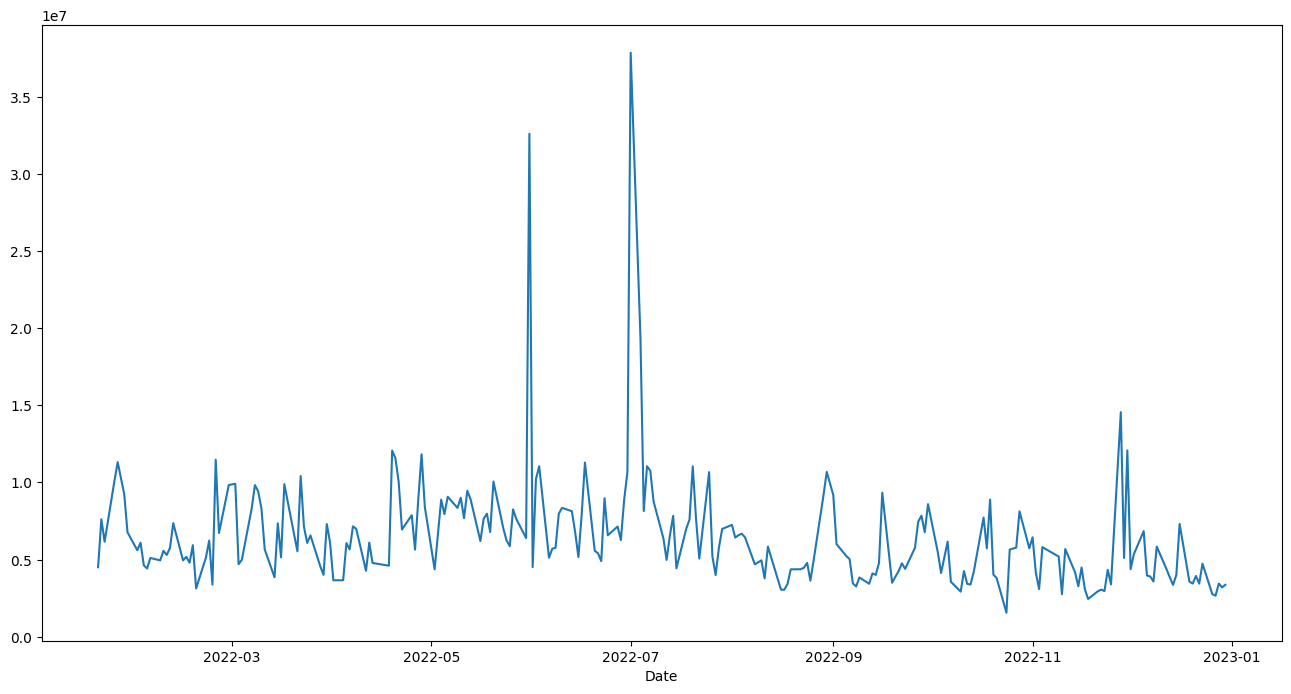

In [ ]:
stock_df1['Volume'][1000:].plot()

In [ ]:
stock_df1['Daily Return'] = stock_df1['Adj Close'].pct_change()

<Axes: xlabel='Date'>

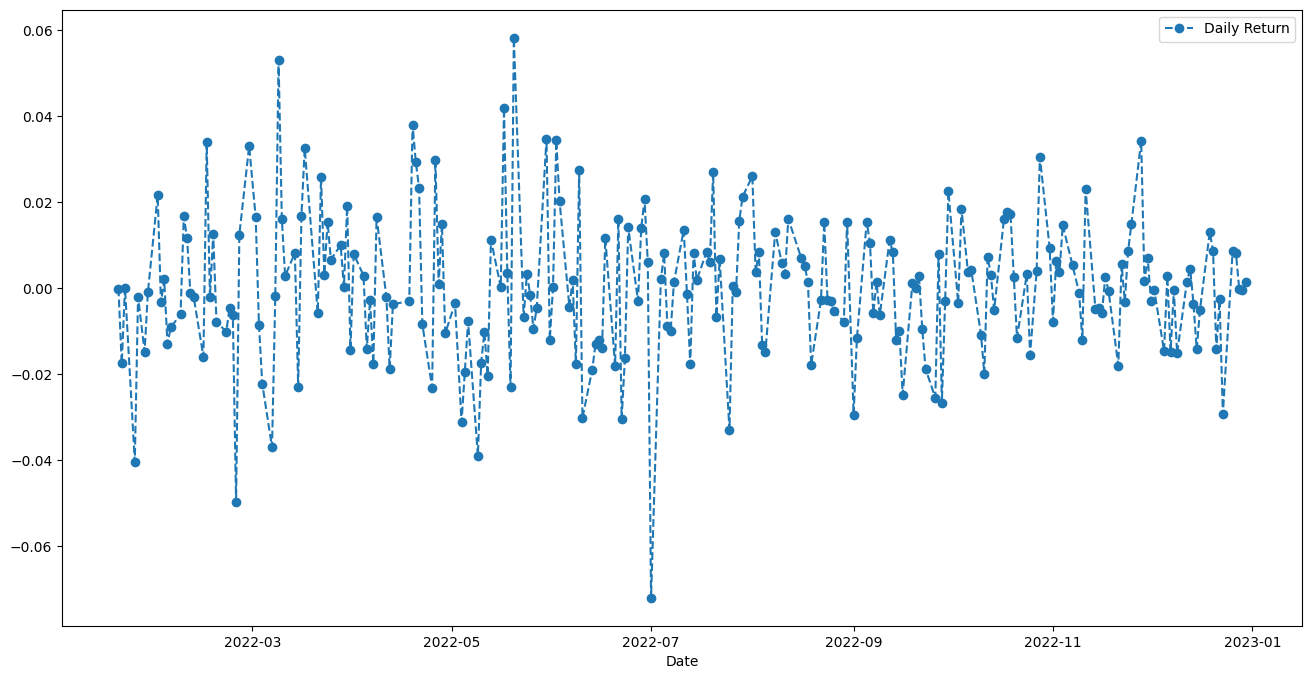

In [ ]:
stock_df1['Daily Return'][1000:].plot(legend=True, linestyle= '--', marker='o')

<Axes: xlabel='Daily Return', ylabel='Density'>

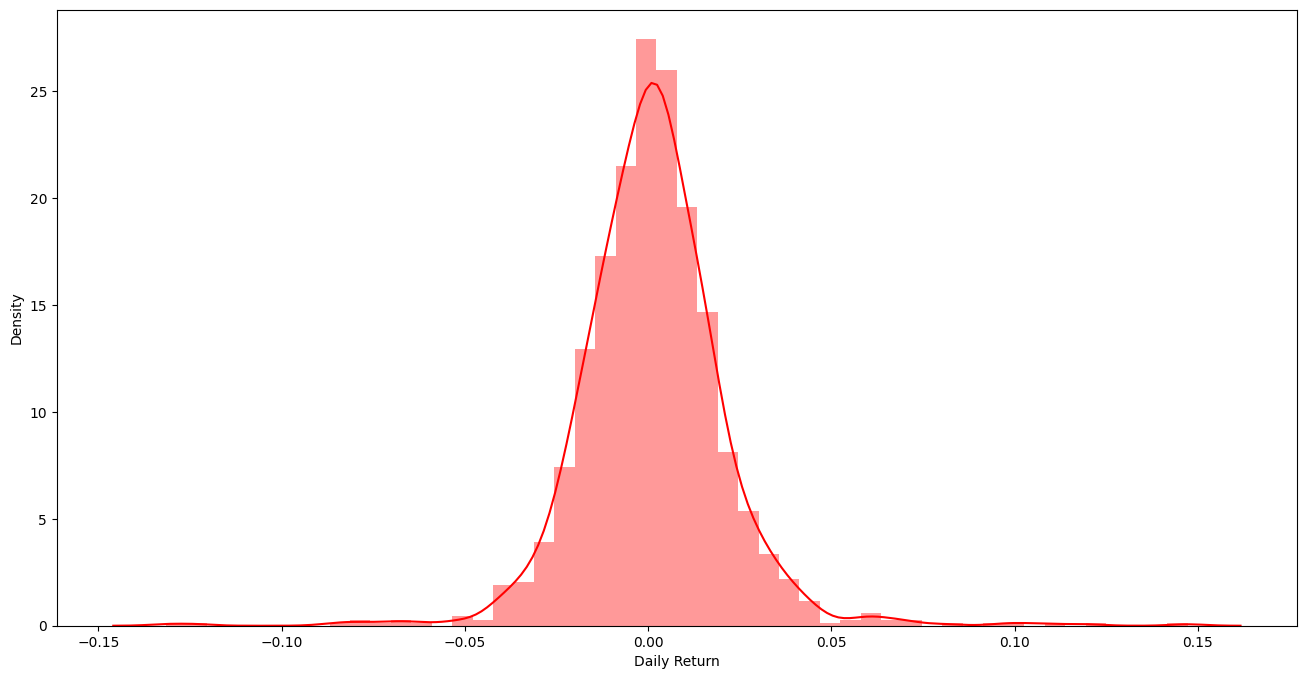

In [ ]:
sns.distplot(stock_df1['Daily Return'],kde=True,color='red',bins=50)

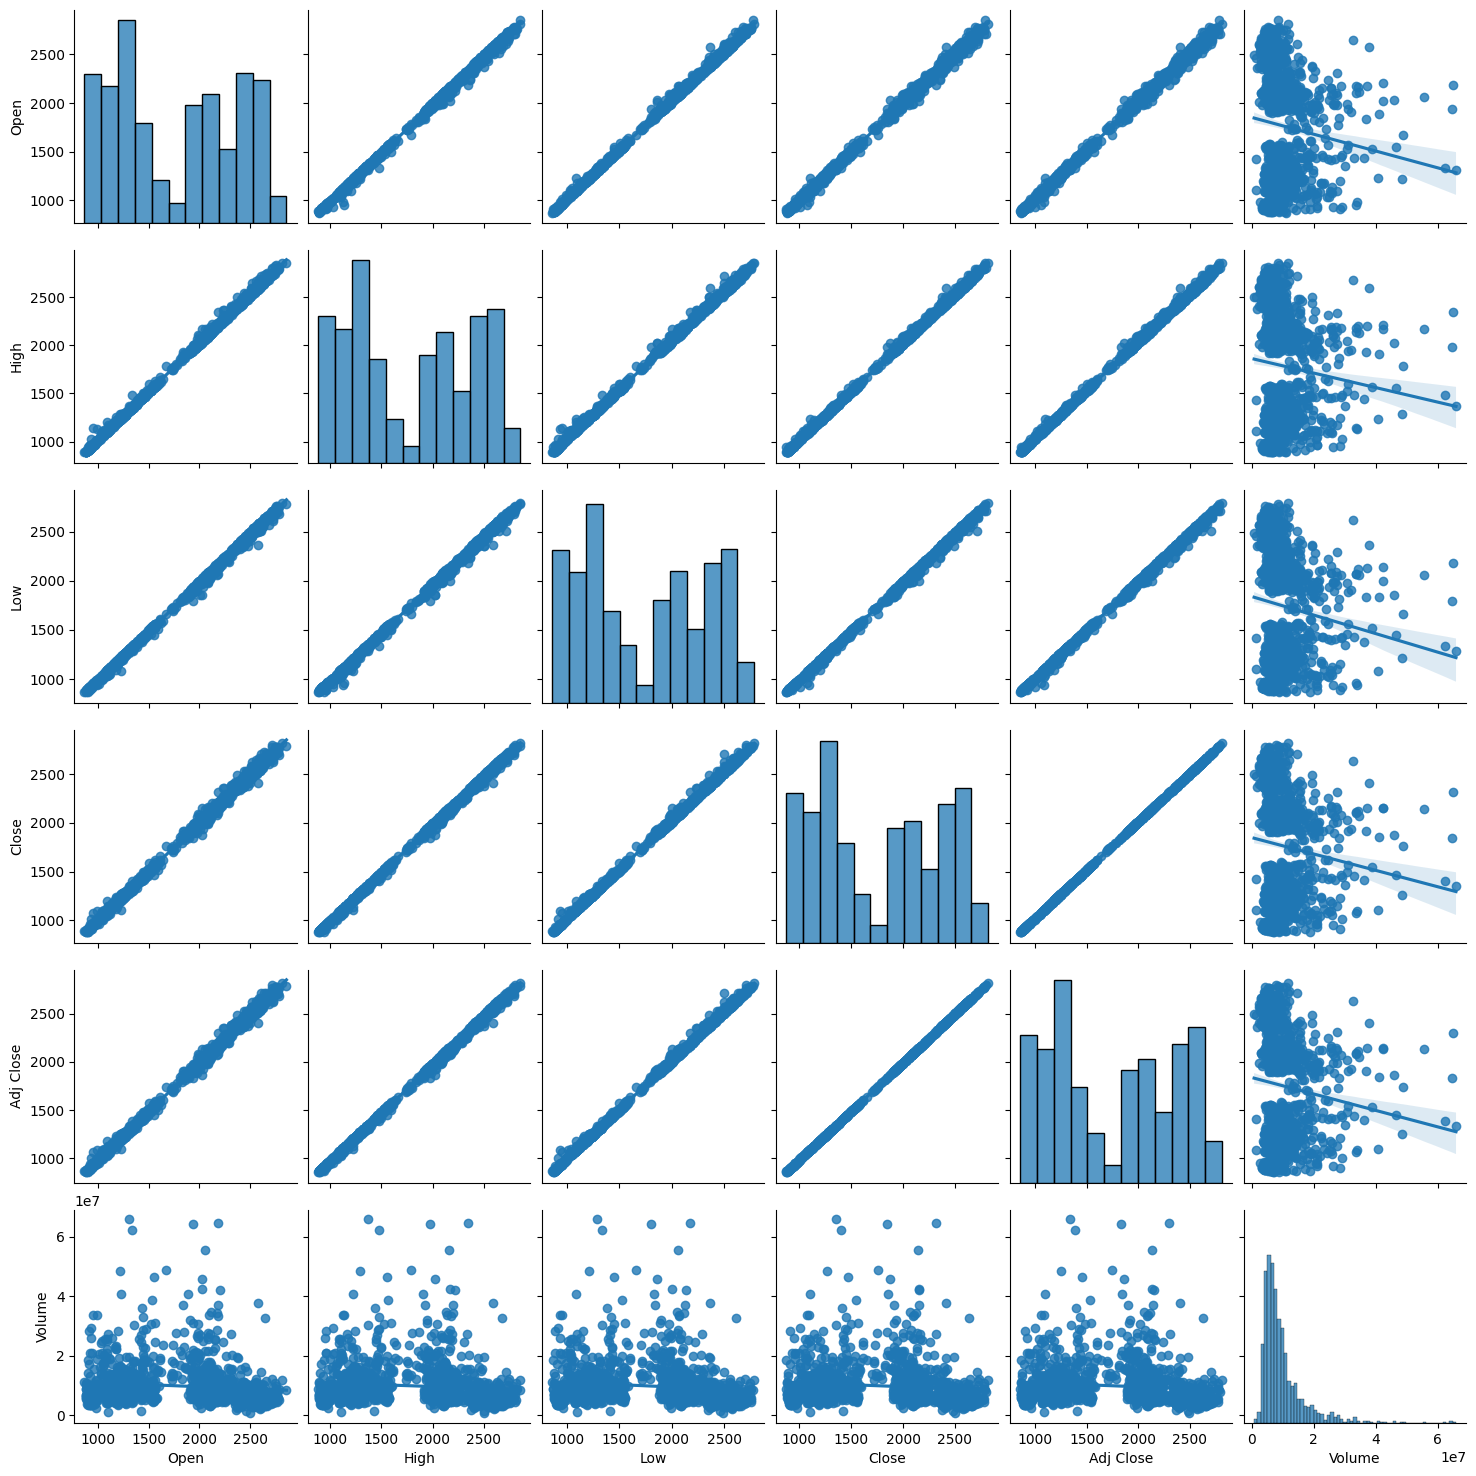

In [ ]:
sns.pairplot(stock_df,kind='reg')

[Text(0.5, 1.0, 'Correlation Plot')]

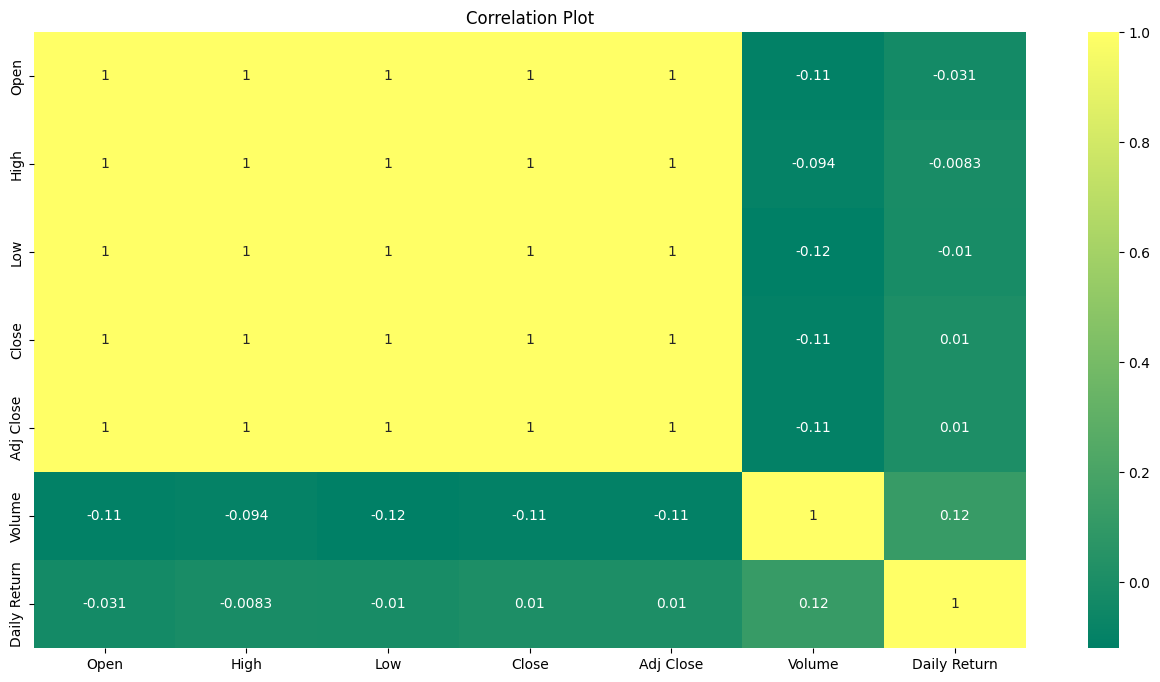

In [ ]:
sns.heatmap(stock_df1.corr(), annot=True, cmap='summer').set(title="Correlation Plot")

In [ ]:
stock_senti_df=pd.merge(stock_df,tweet_score_df,on='Date',how='left')

In [ ]:
stock_senti_df.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Negative     25
Neutral      25
Positive     25
dtype: int64

In [ ]:
stock_senti_df.fillna(method='bfill',inplace=True)

In [ ]:
stock_senti_df['SMA_50'] = stock_senti_df.iloc[:,5].rolling(window=50).mean()
stock_senti_df['SMA_100'] = stock_senti_df.iloc[:,5].rolling(window=100).mean()
stock_senti_df['SMA_200'] = stock_senti_df.iloc[:,5].rolling(window=200).mean()

# Analyzing the trend

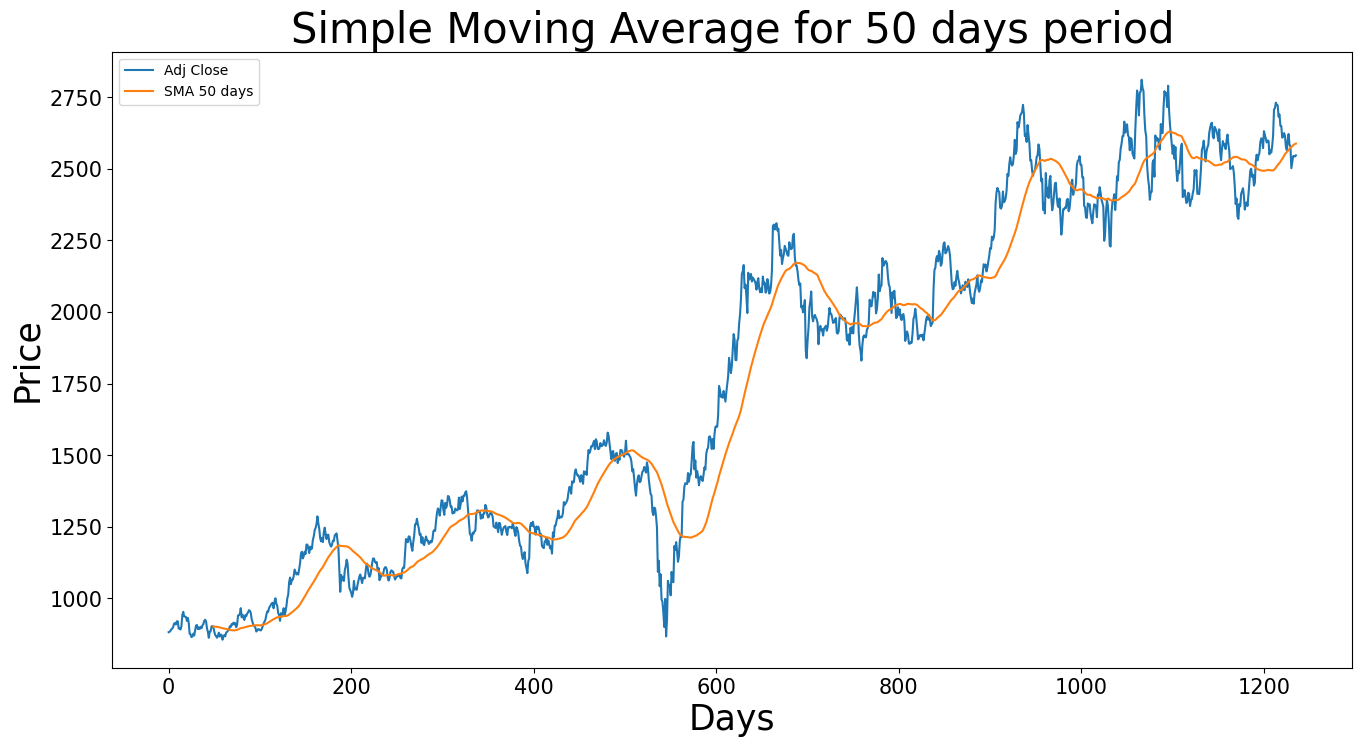

In [ ]:
plt.plot(stock_senti_df['Adj Close'],label='Adj Close')
plt.plot(stock_senti_df['SMA_50'],label='SMA 50 days')
plt.legend(loc=2)
plt.title("Simple Moving Average for 50 days period",fontsize=30)
plt.xlabel("Days",fontsize=25)
plt.ylabel("Price",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

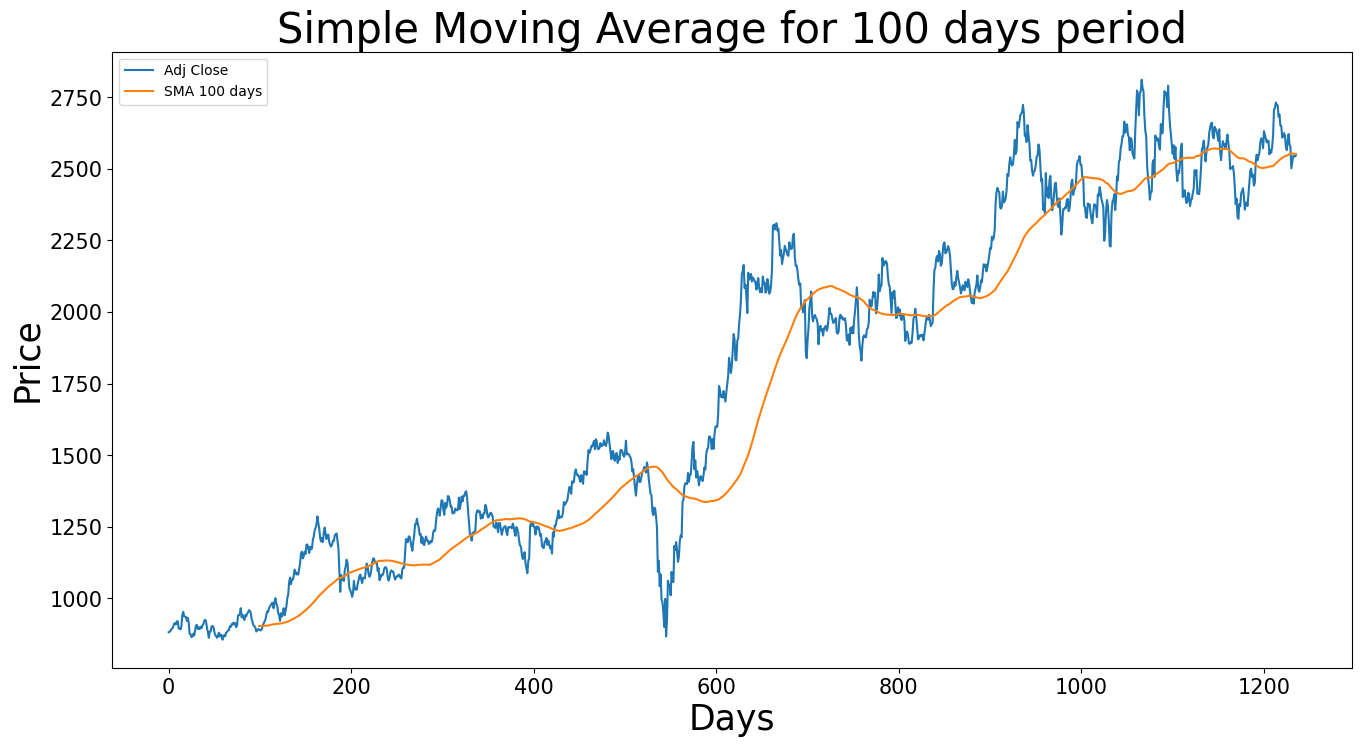

In [ ]:
plt.plot(stock_senti_df['Adj Close'],label='Adj Close')
plt.plot(stock_senti_df['SMA_100'],label='SMA 100 days')
plt.legend(loc=2)
plt.title("Simple Moving Average for 100 days period",fontsize=30)
plt.xlabel("Days",fontsize=25)
plt.ylabel("Price",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

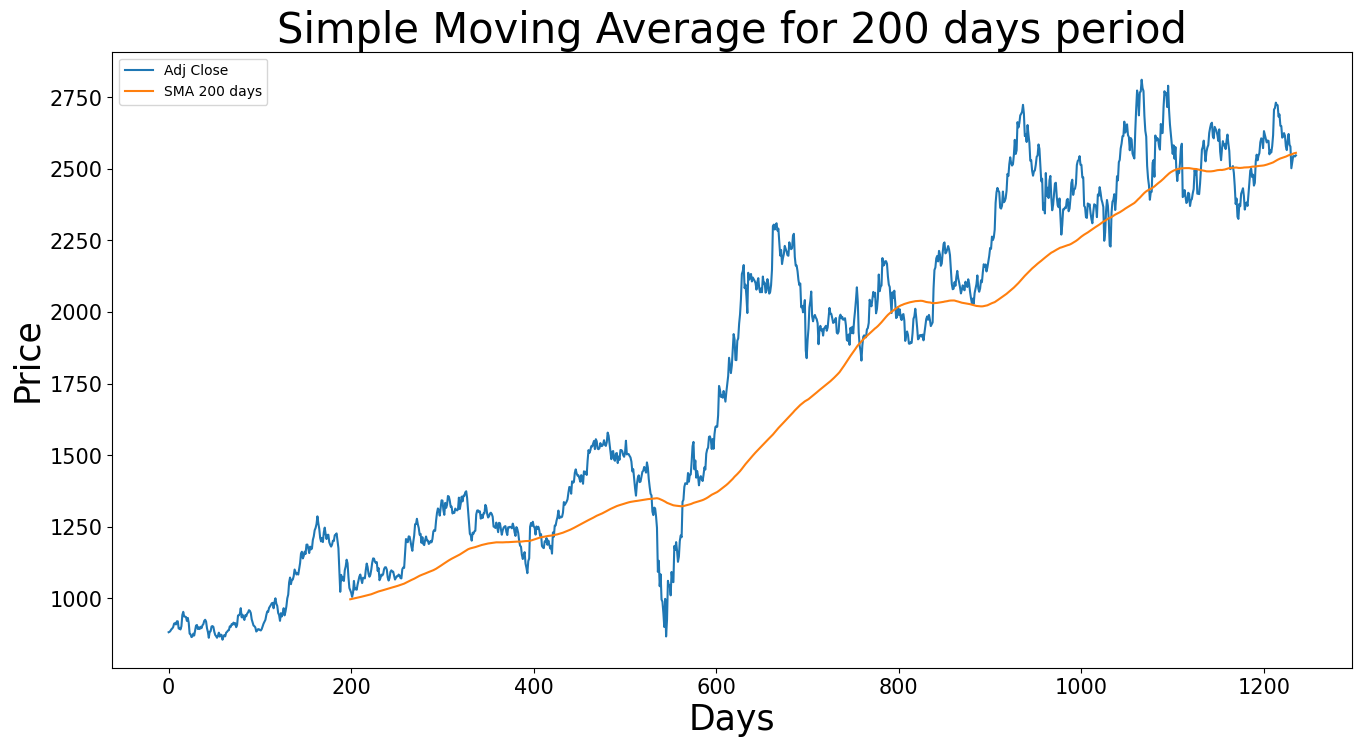

In [ ]:
plt.plot(stock_senti_df['Adj Close'],label='Adj Close')
plt.plot(stock_senti_df['SMA_200'],label='SMA 200 days')
plt.legend(loc=2)
plt.title("Simple Moving Average for 200 days period",fontsize=30)
plt.xlabel("Days",fontsize=25)
plt.ylabel("Price",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
stock_senti_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Negative', 'Neutral', 'Positive', 'SMA_50', 'SMA_100', 'SMA_200'],
      dtype='object')

In [ ]:
stock_senti_df=stock_senti_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Negative', 'Neutral', 'Positive','Adj Close']]

[Text(0.5, 1.0, 'Correlation Plot')]

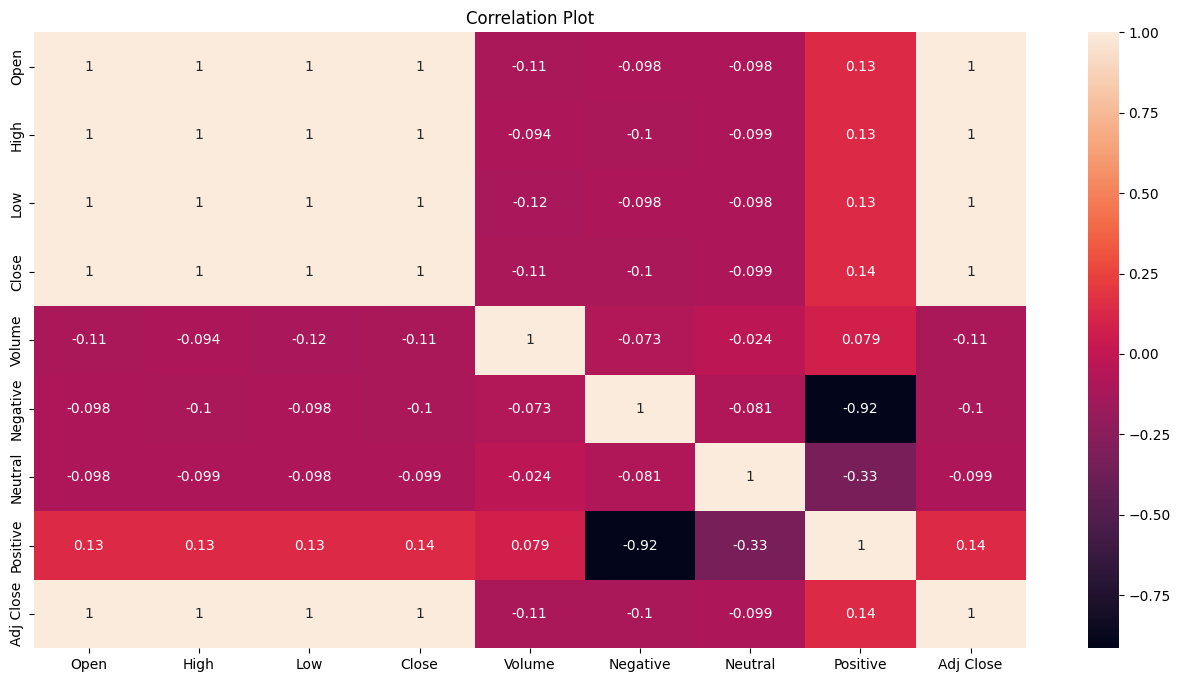

In [ ]:
sns.heatmap(stock_senti_df.corr(),annot=True).set(title='Correlation Plot')

In [ ]:
date=stock_senti_df['Date']

In [ ]:
stock_senti_df.set_index('Date',inplace=True)

In [ ]:
stock_senti_df=stock_senti_df.dropna(axis=0)

In [ ]:
training_size=int(len(stock_senti_df)*0.65)
test_size=len(stock_senti_df)-training_size
train_data,test_data=stock_senti_df.iloc[0:training_size,:],stock_senti_df.iloc[training_size:len(stock_senti_df),:]

In [ ]:
train_data

,Open,High,Low,Close,Volume,Negative,Neutral,Positive,Adj Close
Date,,,,,,,,,
2018-01-01,914.035828,914.035828,898.978577,901.207458,4362651,0.0,0.0,1.0,881.918274
2018-01-02,904.426941,910.915405,897.888916,902.594299,4383980,0.0,0.0,1.0,883.275391
2018-01-03,916.314270,917.304871,904.476440,906.210022,6233847,1.0,0.0,0.0,886.813721
2018-01-04,909.528564,913.144287,907.101563,911.658386,4157621,1.0,0.0,0.0,892.145386
2018-01-05,913.144287,918.196411,911.608887,914.580688,3434151,1.0,0.0,0.0,895.005188
...,...,...,...,...,...,...,...,...,...
2021-03-26,2012.000000,2013.699951,1973.699951,1994.650024,9313160,0.0,0.0,1.0,1982.285889
2021-03-30,2008.000000,2048.899902,1991.550049,2029.300049,9433842,1.0,0.0,0.0,2016.721069
2021-03-31,2018.000000,2049.899902,1999.000000,2003.099976,7499740,1.0,0.0,0.0,1990.683350


In [ ]:
test_data.head(15)

,Open,High,Low,Close,Volume,Negative,Neutral,Positive,Adj Close
Date,,,,,,,,,
2021-04-06,2004.000000,2004.949951,1969.000000,1984.300049,6465241,0.0,0.0,1.0,1972.000000
2021-04-07,2000.000000,2046.900024,1993.300049,2002.849976,11198918,0.0,0.0,1.0,1990.434937
2021-04-08,2011.000000,2022.000000,1993.000000,2005.349976,7092878,1.0,0.0,0.0,1992.919434
2021-04-09,1998.449951,2006.349976,1980.000000,1982.050049,6478482,0.0,0.0,1.0,1969.764038
2021-04-12,1959.000000,1961.400024,1900.250000,1911.150024,9646031,0.0,0.0,1.0,1899.303467
2021-04-13,1924.000000,1940.599976,1917.849976,1931.800049,8958261,0.0,0.0,1.0,1919.825439
2021-04-15,1926.300049,1961.000000,1913.000000,1944.300049,9102492,0.0,0.0,1.0,1932.247925
2021-04-16,1936.599976,1949.900024,1926.449951,1932.099976,7225679,0.0,0.0,1.0,1920.123535
2021-04-19,1904.000000,1916.400024,1890.000000,1901.699951,8527967,0.0,0.0,1.0,1889.911865


In [ ]:
train_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Negative', 'Neutral',
       'Positive', 'Adj Close'],
      dtype='object')

In [ ]:
train=train_data[['Negative', 'Neutral',
       'Positive', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Adj Close']]
test=test_data[['Negative', 'Neutral',
       'Positive', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Adj Close']]

In [ ]:
convert_dict = {'Negative': int,
                'Neutral': int,
                'Positive': int}

In [ ]:
train = train.astype(convert_dict)
test = test.astype(convert_dict)

In [ ]:
test.head()

,Negative,Neutral,Positive,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,,,,
2021-04-06,0,0,1,2004.000000,2004.949951,1969.000000,1984.300049,6465241,1972.000000
2021-04-07,0,0,1,2000.000000,2046.900024,1993.300049,2002.849976,11198918,1990.434937
2021-04-08,1,0,0,2011.000000,2022.000000,1993.000000,2005.349976,7092878,1992.919434
2021-04-09,0,0,1,1998.449951,2006.349976,1980.000000,1982.050049,6478482,1969.764038
2021-04-12,0,0,1,1959.000000,1961.400024,1900.250000,1911.150024,9646031,1899.303467


In [ ]:
scaler1 = MinMaxScaler()
train[['Open', 'High', 'Low','Close', 'Volume',
       'Adj Close']]= scaler1.fit_transform(
           train[['Open', 'High', 'Low','Close', 'Volume', 'Adj Close']])

In [ ]:
scaler2 = MinMaxScaler()
test[['Open', 'High', 'Low','Close', 'Volume',
       'Adj Close']] = scaler2.fit_transform(test[['Open', 'High', 'Low','Close', 'Volume',
       'Adj Close']])

In [ ]:
test.columns

Index(['Negative', 'Neutral', 'Positive', 'Open', 'High', 'Low', 'Close',
       'Volume', 'Adj Close'],
      dtype='object')

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset.iloc[i:(i+time_step), :8]
    dataX.append(a)
    dataY.append(dataset.iloc[i + time_step, 8])
  return numpy.array(dataX), numpy.array(dataY)
time_step = 10
X_train, y_train = create_dataset(train, 10)
X_test, y_test = create_dataset(test, 10)

In [ ]:
X_train.shape

(792, 10, 8)

In [ ]:
y_train.shape

(792,)

In [ ]:
X_test.shape

(422, 10, 8)

In [ ]:
y_test.shape

(422,)

In [ ]:
X_train[0]

array([[0.        , 0.        , 1.        , 0.03108761, 0.01794832,
        0.02497518, 0.01847825, 0.04750394],
       [0.        , 0.        , 1.        , 0.02448917, 0.01584265,
        0.02422251, 0.0194346 , 0.04783436],
       [1.        , 0.        , 0.        , 0.03265223, 0.02015429,
        0.02877276, 0.02192796, 0.07649128],
       [1.        , 0.        , 0.        , 0.02799247, 0.01734671,
        0.03058603, 0.0256851 , 0.04432775],
       [1.        , 0.        , 0.        , 0.03047539, 0.0207559 ,
        0.03369941, 0.02770028, 0.03312023],
       [1.        , 0.        , 0.        , 0.0334005 , 0.02349663,
        0.03592322, 0.0313208 , 0.04302721],
       [1.        , 0.        , 0.        , 0.03479503, 0.03211986,
        0.03626534, 0.03979141, 0.08211611],
       [0.        , 0.        , 1.        , 0.04489681, 0.03445948,
        0.0441342 , 0.04074776, 0.06376477],
       [0.        , 0.        , 1.        , 0.04408047, 0.03128427,
        0.04379208, 0.037605

In [ ]:
y_train[0]

0.04428982071278942

In [ ]:
X_test[0]

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.15935275e-01,
        9.61027978e-02, 1.01495529e-01, 9.05083469e-02, 1.37077127e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.11785466e-01,
        1.40649973e-01, 1.28216493e-01, 1.10699841e-01, 2.51354969e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.23197440e-01,
        1.14208405e-01, 1.27886552e-01, 1.13421077e-01, 1.52229196e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.10177365e-01,
        9.75894975e-02, 1.13591414e-01, 8.80592342e-02, 1.37396784e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 6.92499292e-02,
        4.98567224e-02, 2.58962450e-02, 1.08849452e-02, 2.13866020e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 3.29391049e-02,
        2.77689565e-02, 4.52496353e-02, 3.33623844e-02, 1.97262253e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 3.53252956e-02,
        4.94319331e-02, 3.99164758e-02, 4.69685659e-02, 2.

In [ ]:
y_test[0]

0.005658801127635726

In [ ]:
stock_train=train[['Open', 'High', 'Low', 'Close',
       'Volume', 'Adj Close']]
stock_test=test[['Open', 'High', 'Low', 'Close',
       'Volume', 'Adj Close']]

def create_dataset1(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset.iloc[i:(i+time_step), :5]
    dataX.append(a)
    dataY.append(dataset.iloc[i + time_step, 5])
  return numpy.array(dataX), numpy.array(dataY)
time_step = 10
X_train_stock, y_train_stock = create_dataset1(stock_train, 10)
X_test_stock, y_test_stock = create_dataset1(stock_test, 10)

stock_test.head(11)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2021-04-06,0.115935,0.096103,0.101496,0.090508,0.137077,0.089623
2021-04-07,0.111785,0.140650,0.128216,0.110700,0.251355,0.109618
2021-04-08,0.123197,0.114208,0.127887,0.113421,0.152229,0.112312
2021-04-09,0.110177,0.097589,0.113591,0.088059,0.137397,0.087198
2021-04-12,0.069250,0.049857,0.025896,0.010885,0.213866,0.010779
2021-04-13,0.032939,0.027769,0.045250,0.033362,0.197262,0.033036
2021-04-15,0.035325,0.049432,0.039916,0.046969,0.200744,0.046509
2021-04-16,0.046011,0.037645,0.054706,0.033689,0.155435,0.033360
2021-04-19,0.012190,0.002071,0.014625,0.000599,0.186874,0.000593


In [ ]:
X_train_stock[0]

array([[0.03108761, 0.01794832, 0.02497518, 0.01847825, 0.04750394],
       [0.02448917, 0.01584265, 0.02422251, 0.0194346 , 0.04783436],
       [0.03265223, 0.02015429, 0.02877276, 0.02192796, 0.07649128],
       [0.02799247, 0.01734671, 0.03058603, 0.0256851 , 0.04432775],
       [0.03047539, 0.0207559 , 0.03369941, 0.02770028, 0.03312023],
       [0.0334005 , 0.02349663, 0.03592322, 0.0313208 , 0.04302721],
       [0.03479503, 0.03211986, 0.03626534, 0.03979141, 0.08211611],
       [0.04489681, 0.03445948, 0.0441342 , 0.04074776, 0.06376477],
       [0.04408047, 0.03128427, 0.04379208, 0.03760543, 0.03603632],
       [0.04489681, 0.03806921, 0.04601589, 0.04529045, 0.08766814]])

In [ ]:
y_train_stock[0]

0.04428982071278942

In [ ]:
X_test_stock[0]

array([[0.11593527, 0.0961028 , 0.10149553, 0.09050835, 0.13707713],
       [0.11178547, 0.14064997, 0.12821649, 0.11069984, 0.25135497],
       [0.12319744, 0.1142084 , 0.12788655, 0.11342108, 0.1522292 ],
       [0.11017736, 0.0975895 , 0.11359141, 0.08805923, 0.13739678],
       [0.06924993, 0.04985672, 0.02589624, 0.01088495, 0.21386602],
       [0.0329391 , 0.02776896, 0.04524964, 0.03336238, 0.19726225],
       [0.0353253 , 0.04943193, 0.03991648, 0.04696857, 0.2007442 ],
       [0.04601098, 0.03764476, 0.05470639, 0.03368885, 0.15543521],
       [0.01219006, 0.0020708 , 0.01462508, 0.00059859, 0.18687433],
       [0.0189335 , 0.00483174, 0.01511986, 0.        , 0.17266764]])

In [ ]:
y_test_stock[0]

0.005658801127635726

In [ ]:
test_tweet=pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Project/Test_tweet.csv')

In [ ]:
test_stock=pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Project/Test_Reliance.csv')

In [ ]:
test_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  386 non-null    object
 1   User      386 non-null    object
 2   Tweet     386 non-null    object
dtypes: object(3)
memory usage: 9.2+ KB


In [ ]:
test_tweet.duplicated().sum()

0

In [ ]:
test_tweet['Date']=pd.to_datetime(test_tweet['DateTime']).dt.date


In [ ]:
test_tweet.drop(['DateTime','User'],axis=1,inplace=True)

In [ ]:
test_tweet=test_tweet[['Date','Tweet']]

In [ ]:
test_tweet['Tweet']=test_tweet['Tweet'].apply(preprocess)

In [ ]:
test_tweet['Score']=test_tweet['Tweet'].apply(sentiment_scores)

In [ ]:
test_tweet['Polarity']=test_tweet['Score'].apply(label)

In [ ]:
test_tweet

,Date,Tweet,Score,Polarity
0,2023-02-28,The expanding conflict between the US and Chin...,0.0772,POS
1,2023-02-28,"""We are on the path to achieve the declared go...",0.3182,POS
2,2023-02-28,"Based on the scores, Reliance Jio is behind on...",0.0000,NEU
3,2023-02-28,"""We are on the path to achieve the declared go...",0.3182,POS
4,2023-02-28,A new video of billionaire Mukesh Ambani's you...,0.7003,POS
...,...,...,...,...
381,2023-01-03,Bidders and creditors often override deadlines...,0.0000,NEU
382,2023-01-03,Strong performance across segments is expected...,0.7964,POS
383,2023-01-03,SKS Power Generation’s lenders have received s...,-0.4019,NEG
384,2023-01-03,Torrent Investments has pleaded with the NCL...,-0.2924,NEG


In [ ]:
pos_tweet=test_tweet.query('Polarity=="POS"')['Tweet']
neg_tweet=test_tweet.query('Polarity=="NEG"')['Tweet']
neu_tweet=test_tweet.query('Polarity=="NEU"')['Tweet']

In [ ]:
test_tweet=pd.DataFrame(test_tweet.groupby([test_tweet['Date']]).mean())

In [ ]:
test_tweet['Sentiment']=test_tweet['Score'].apply(Sentiment)

In [ ]:
test_tweet

,Score,Sentiment
Date,,
2023-01-03,0.042406,2
2023-01-04,0.104886,2
2023-01-05,0.242527,2
2023-01-06,0.152407,2
2023-01-07,0.042667,2
2023-01-08,-0.064000,0
2023-01-09,0.098667,2
2023-01-10,0.265655,2
2023-01-11,-0.022337,0


In [ ]:
test_tweet=pd.get_dummies(test_tweet['Sentiment'],drop_first=False)

In [ ]:
test_tweet.columns=['Negative','Positive']

In [ ]:
test_tweet=test_tweet[['Negative','Positive']]

In [ ]:
test_stock['Date']=pd.to_datetime(test_stock['Date']).dt.date

In [ ]:
test_stock.dropna(axis=0,inplace=True)

In [ ]:
test_stock.reset_index(inplace=True)

In [ ]:
test_stock_senti=pd.merge(test_stock,test_tweet,on='Date',how='left')

In [ ]:
test_stock_senti.isna().sum()

index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Negative     2
Positive     2
dtype: int64

In [ ]:
test_stock_senti.fillna(method='bfill',inplace=True)
test_stock_senti.fillna(method='ffill',inplace=True)

In [ ]:
test_stock_senti.set_index('Date',inplace=True)
test_stock.set_index('Date',inplace=True)

In [ ]:
test_stock_senti=test_stock_senti[['Open', 'High', 'Low', 'Close', 'Volume',
       'Negative', 'Positive','Adj Close']]
test_stock_wo_senti=test_stock[['Open', 'High', 'Low', 'Close',
       'Volume', 'Adj Close']]

In [ ]:
scaler3=MinMaxScaler()
test_stock_senti[['Open', 'High', 'Low', 'Close', 'Volume',
       'Adj Close']]=scaler3.fit_transform(test_stock_senti[['Open', 'High', 'Low', 'Close', 'Volume',
       'Adj Close']])

In [ ]:
scaler4=MinMaxScaler()
test_stock_wo_senti[['Open', 'High', 'Low', 'Close',
       'Volume', 'Adj Close']]=scaler4.fit_transform(test_stock_wo_senti[['Open', 'High', 'Low', 'Close',
       'Volume', 'Adj Close']])

In [ ]:
def create_dataset2(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset.iloc[i:(i+time_step), :7]
    dataX.append(a)
    dataY.append(dataset.iloc[i + time_step, 7])
  return numpy.array(dataX), numpy.array(dataY)

In [ ]:
x_stock, y_stock= create_dataset1(test_stock_wo_senti, 10)
x_senti,y_senti=create_dataset2(test_stock_senti,10)

In [ ]:
x_stock[0]

array([[0.86071445, 0.88421053, 1.        , 0.86335517, 0.04821888],
       [0.83333333, 0.84228087, 0.86734677, 0.73100735, 0.10736154],
       [0.71938776, 0.75578913, 0.82810031, 0.71553813, 0.2683768 ],
       [0.73010171, 0.79631562, 0.88422294, 0.79408691, 0.        ],
       [0.79353758, 0.98596491, 0.98253552, 1.        , 0.16105021],
       [1.        , 1.        , 0.99293544, 0.86799544, 0.0625155 ],
       [0.81802721, 0.83157895, 0.89521214, 0.75713265, 0.19002568],
       [0.72397993, 0.74210526, 0.67503912, 0.56961194, 0.41758778],
       [0.49795885, 0.53298211, 0.55573026, 0.55586151, 0.52548389],
       [0.54659847, 0.55666632, 0.52590257, 0.47507778, 0.26788907]])

In [ ]:
y_stock[0]

0.5943625288027095

In [ ]:
x_senti[0]

array([[0.86071445, 0.88421053, 1.        , 0.86335517, 0.04821888,
        0.        , 1.        ],
       [0.83333333, 0.84228087, 0.86734677, 0.73100735, 0.10736154,
        0.        , 1.        ],
       [0.71938776, 0.75578913, 0.82810031, 0.71553813, 0.2683768 ,
        0.        , 1.        ],
       [0.73010171, 0.79631562, 0.88422294, 0.79408691, 0.        ,
        0.        , 1.        ],
       [0.79353758, 0.98596491, 0.98253552, 1.        , 0.16105021,
        0.        , 1.        ],
       [1.        , 1.        , 0.99293544, 0.86799544, 0.0625155 ,
        0.        , 1.        ],
       [0.81802721, 0.83157895, 0.89521214, 0.75713265, 0.19002568,
        1.        , 0.        ],
       [0.72397993, 0.74210526, 0.67503912, 0.56961194, 0.41758778,
        1.        , 0.        ],
       [0.49795885, 0.53298211, 0.55573026, 0.55586151, 0.52548389,
        0.        , 1.        ],
       [0.54659847, 0.55666632, 0.52590257, 0.47507778, 0.26788907,
        1.        , 0. 

In [ ]:
y_senti[0]

0.5943625288027095

In [ ]:
model1_w_senti = Sequential()
model1_w_senti.add(LSTM(10,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=True))
model1_w_senti.add(LSTM(5, return_sequences=False))
model1_w_senti.add(Dropout(0.1))
model1_w_senti.add(Dense(120,activation='relu'))
model1_w_senti.add(Dense(75,activation='relu'))
model1_w_senti.add(Dense(1,activation='relu'))
model1_w_senti.compile(loss='mse', optimizer='adam',
                       metrics=[keras.metrics.RootMeanSquaredError()])
model1_w_senti.summary()

# fit the model
history1_w_senti= model1_w_senti.fit(X_train, y_train, epochs=250,
                                     validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 10)            760       
                                                                 
 lstm_5 (LSTM)               (None, 5)                 320       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense_6 (Dense)             (None, 120)               720       
                                                                 
 dense_7 (Dense)             (None, 75)                9075      
                                                                 
 dense_8 (Dense)             (None, 1)                 76        
                                                                 
Total params: 10951 (42.78 KB)
Trainable params: 10951

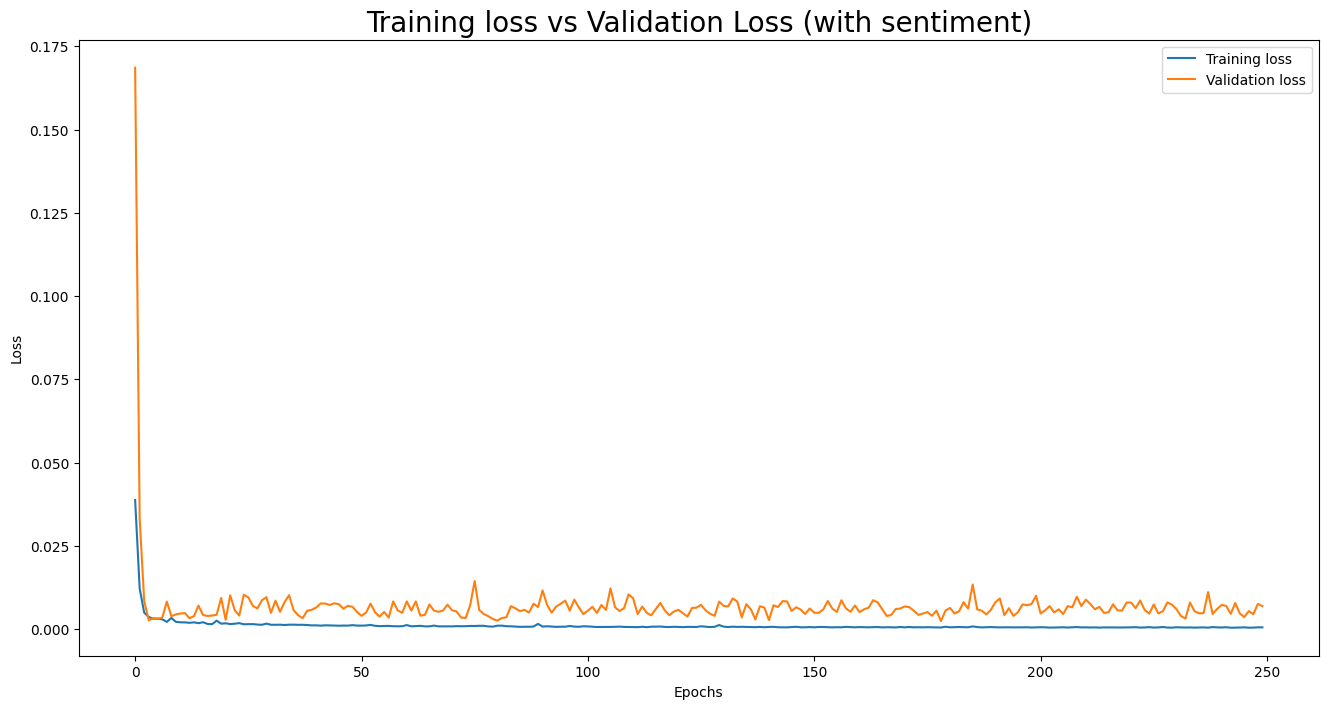

In [ ]:
plt.plot(history1_w_senti.history['loss'], label='Training loss')
plt.plot(history1_w_senti.history['val_loss'], label='Validation loss')
plt.title('Training loss vs Validation Loss (with sentiment)',fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
model1_w_senti.evaluate(X_test,y_test)

14/14 [==============================] - 0s 5ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756


[0.0057123033329844475, 0.07557977735996246]

In [ ]:
model1_wo_senti = Sequential()
model1_wo_senti.add(LSTM(10,
               input_shape=(X_train_stock.shape[1], X_train_stock.shape[2]),
               return_sequences=True))
model1_wo_senti.add(LSTM(5, return_sequences=False))
model1_wo_senti.add(Dropout(0.1))
model1_wo_senti.add(Dense(120,activation='relu'))
model1_wo_senti.add(Dense(75,activation='relu'))
model1_wo_senti.add(Dense(1,activation='relu'))
model1_wo_senti.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model1_wo_senti.summary()

# fit the model
history1_wo_senti= model1_wo_senti.fit(X_train_stock, y_train_stock, epochs=250,
                                     validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 10)            640       
                                                                 
 lstm_7 (LSTM)               (None, 5)                 320       
                                                                 
 dropout_3 (Dropout)         (None, 5)                 0         
                                                                 
 dense_9 (Dense)             (None, 120)               720       
                                                                 
 dense_10 (Dense)            (None, 75)                9075      
                                                                 
 dense_11 (Dense)            (None, 1)                 76        
                                                                 
Total params: 10831 (42.31 KB)
Trainable params: 10831

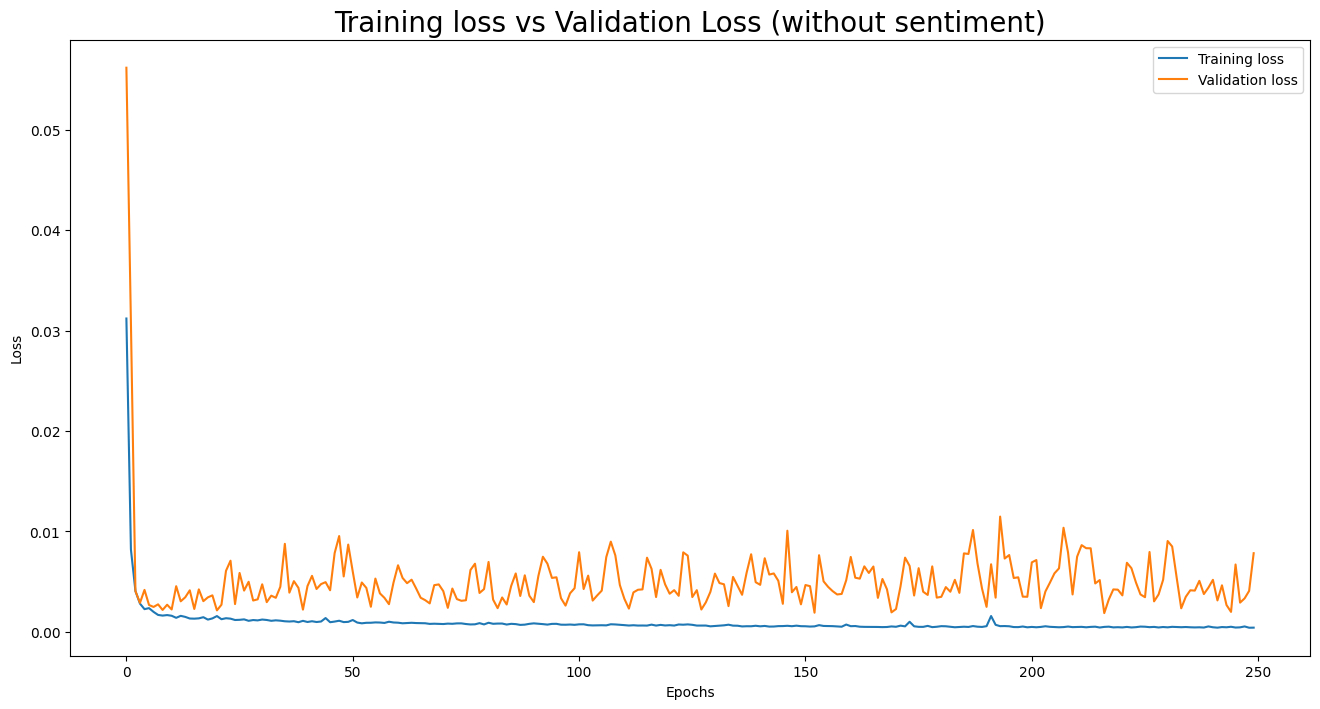

In [ ]:
plt.plot(history1_wo_senti.history['loss'], label='Training loss')
plt.plot(history1_wo_senti.history['val_loss'], label='Validation loss')
plt.title('Training loss vs Validation Loss (without sentiment)',fontsize=20)
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [ ]:
model1_wo_senti.evaluate(X_test_stock,y_test_stock)

14/14 [==============================] - 0s 5ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752


[0.005657507572323084, 0.07521640509366989]

In [ ]:
y_pred_w_senti=model1_w_senti.predict(X_test)
y_pred_w_senti

14/14 [==============================] - 1s 4ms/step


array([[0.02714816],
       [0.0223946 ],
       [0.02123144],
       [0.03142467],
       [0.04899729],
       [0.07721768],
       [0.12960391],
       [0.12933022],
       [0.09743888],
       [0.07312676],
       [0.05094831],
       [0.04169386],
       [0.04709672],
       [0.04724229],
       [0.04071791],
       [0.03422789],
       [0.03499148],
       [0.04514046],
       [0.06718944],
       [0.08612851],
       [0.10053202],
       [0.11622819],
       [0.11727598],
       [0.10845996],
       [0.10186246],
       [0.10495231],
       [0.16057359],
       [0.23590414],
       [0.26653203],
       [0.2790113 ],
       [0.3035235 ],
       [0.2925812 ],
       [0.30461144],
       [0.30681232],
       [0.28685832],
       [0.29174587],
       [0.2985101 ],
       [0.3213199 ],
       [0.33956662],
       [0.31361026],
       [0.29806638],
       [0.3071212 ],
       [0.31563404],
       [0.33090994],
       [0.3200014 ],
       [0.25974286],
       [0.20326988],
       [0.194

In [ ]:
y_pred_wo_senti=model1_wo_senti.predict(X_test_stock)
y_pred_wo_senti

14/14 [==============================] - 1s 4ms/step


array([[0.01870885],
       [0.01576013],
       [0.01731126],
       [0.03172973],
       [0.08537257],
       [0.10701643],
       [0.13599616],
       [0.12232387],
       [0.07755277],
       [0.05722087],
       [0.04926725],
       [0.03428895],
       [0.03952337],
       [0.03820743],
       [0.03580211],
       [0.03065421],
       [0.03434069],
       [0.0595996 ],
       [0.09111793],
       [0.10605374],
       [0.10288307],
       [0.10640632],
       [0.10071459],
       [0.08007166],
       [0.07342039],
       [0.07732533],
       [0.16962552],
       [0.2742091 ],
       [0.29799998],
       [0.30774012],
       [0.32424244],
       [0.29532886],
       [0.3185336 ],
       [0.3117345 ],
       [0.28079686],
       [0.28566033],
       [0.3027167 ],
       [0.33570087],
       [0.35088244],
       [0.30950055],
       [0.30027282],
       [0.31127197],
       [0.324637  ],
       [0.33175218],
       [0.30852944],
       [0.23782727],
       [0.18436395],
       [0.182

In [ ]:
#calculate r-squared
r2= metrics.r2_score(y_test_stock,y_pred_wo_senti)
N=y_test.shape[0]
p=5
x = (1-r2)
y = (N-1) / (N-p-1)
adj_rsquared = (1 - (x * y))
print("Adjusted-R2 : " , adj_rsquared)

Adjusted-R2 :  0.889992366230122


In [ ]:
#calculate r-squared
r2= metrics.r2_score(y_test,y_pred_w_senti)
N=y_test.shape[0]
p=8
x = (1-r2)
y = (N-1) / (N-p-1)
adj_rsquared = (1 - (x * y))
print("Adjusted-R2 : " , adj_rsquared)

Adjusted-R2 :  0.8881200561271181


In [ ]:
y_test_pred_stock=model1_wo_senti.predict(x_stock)

1/1 [==============================] - 0s 27ms/step


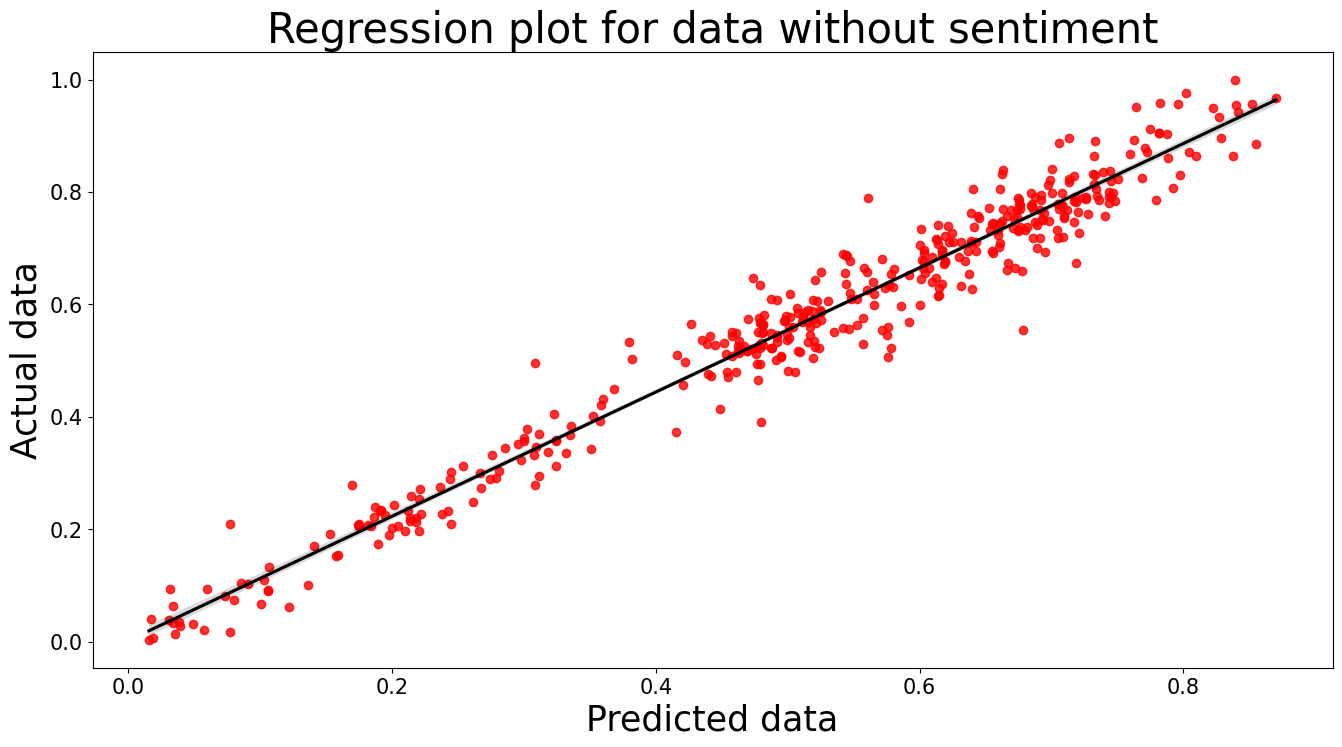

In [ ]:
p2=sns.regplot(x=y_pred_wo_senti,y=y_test_stock,
            scatter_kws={"color": "red"},
            line_kws={"color": "black"})
p2.axes.set_title("Regression plot for data without sentiment",fontsize=30)
p2.axes.set_xlabel("Predicted data",fontsize=25)
p2.axes.set_ylabel("Actual data",fontsize=25)
p2.tick_params(labelsize=15)
plt.show()

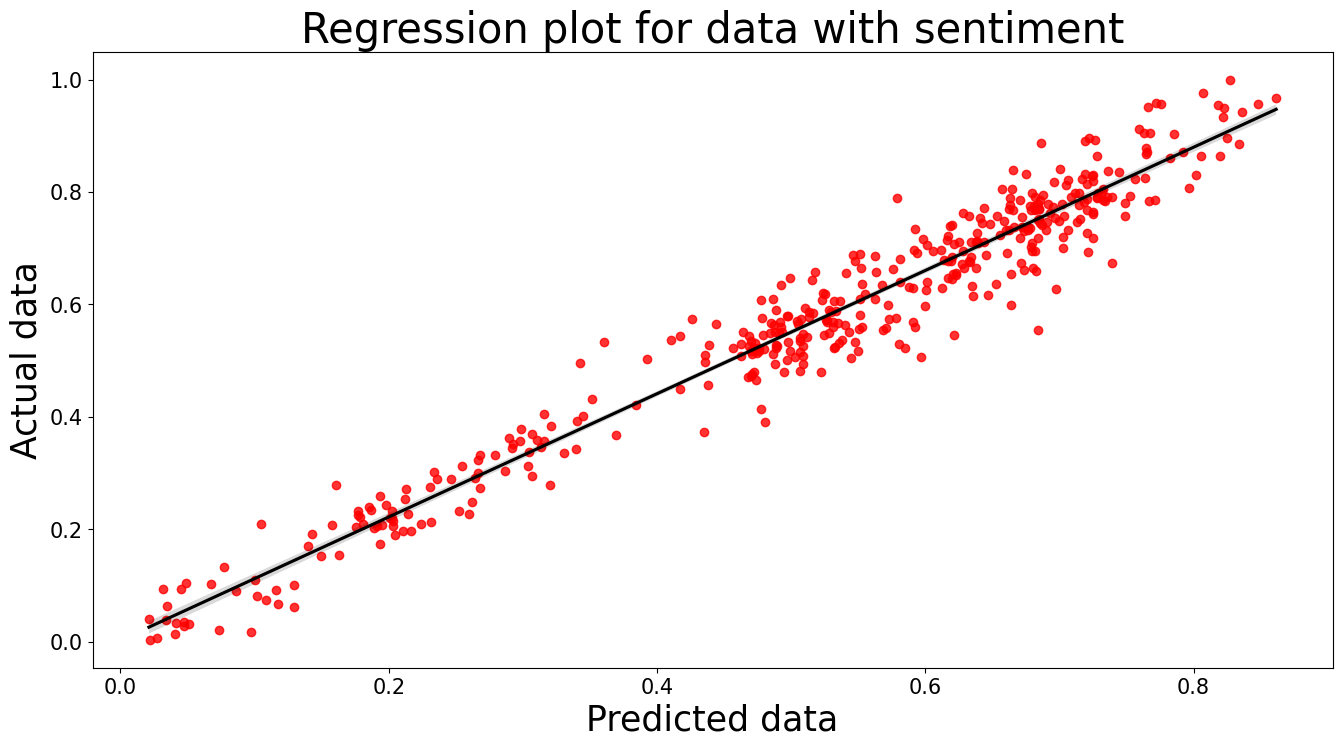

In [ ]:
p1=sns.regplot(x=y_pred_w_senti,y=y_test,
            scatter_kws={"color": "red"},
            line_kws={"color": "black"})
p1.axes.set_title("Regression plot for data with sentiment",fontsize=30)
p1.axes.set_xlabel("Predicted data",fontsize=25)
p1.axes.set_ylabel("Actual data",fontsize=25)
p1.tick_params(labelsize=15)
plt.show()

In [ ]:
# 2021-04-22
test_date=date.iloc[813:1235]
test_date

813     2021-04-22
814     2021-04-23
815     2021-04-26
816     2021-04-27
817     2021-04-28
           ...    
1230    2022-12-23
1231    2022-12-26
1232    2022-12-27
1233    2022-12-28
1234    2022-12-29
Name: Date, Length: 422, dtype: object

In [ ]:
ytestd=pd.DataFrame(test_date)

In [ ]:
ytestd.reset_index(drop=True,inplace=True)

In [ ]:
ytestd['ytest']=y_test_stock

In [ ]:
ytestd['ypred']=y_pred_wo_senti

In [ ]:
ytestd['ypreds']=y_pred_w_senti

In [ ]:
ytestd.set_index('Date',inplace=True)

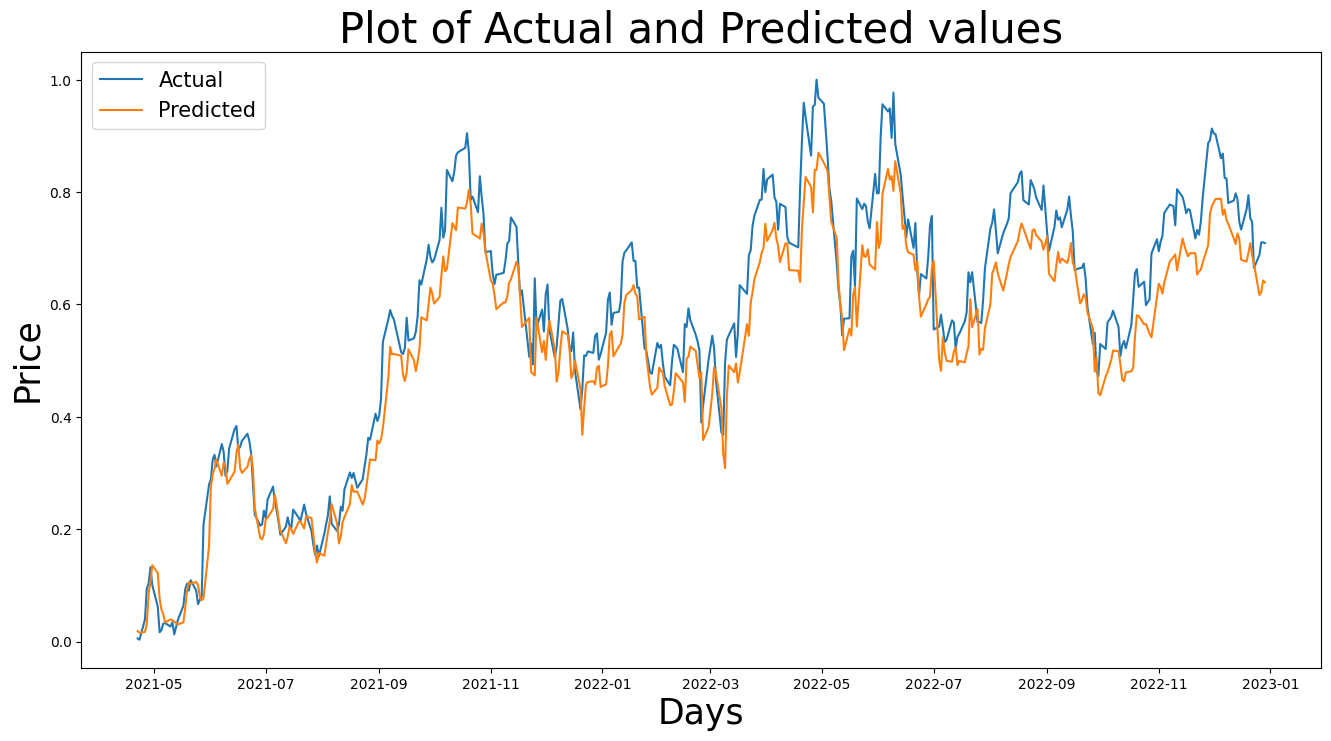

In [ ]:
ytestd['ytest'].plot()
ytestd['ypred'].plot()
plt.title('Plot of Actual and Predicted values',fontsize=30)
plt.xlabel('Days',fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.legend(['Actual','Predicted'],fontsize=15)
plt.show()

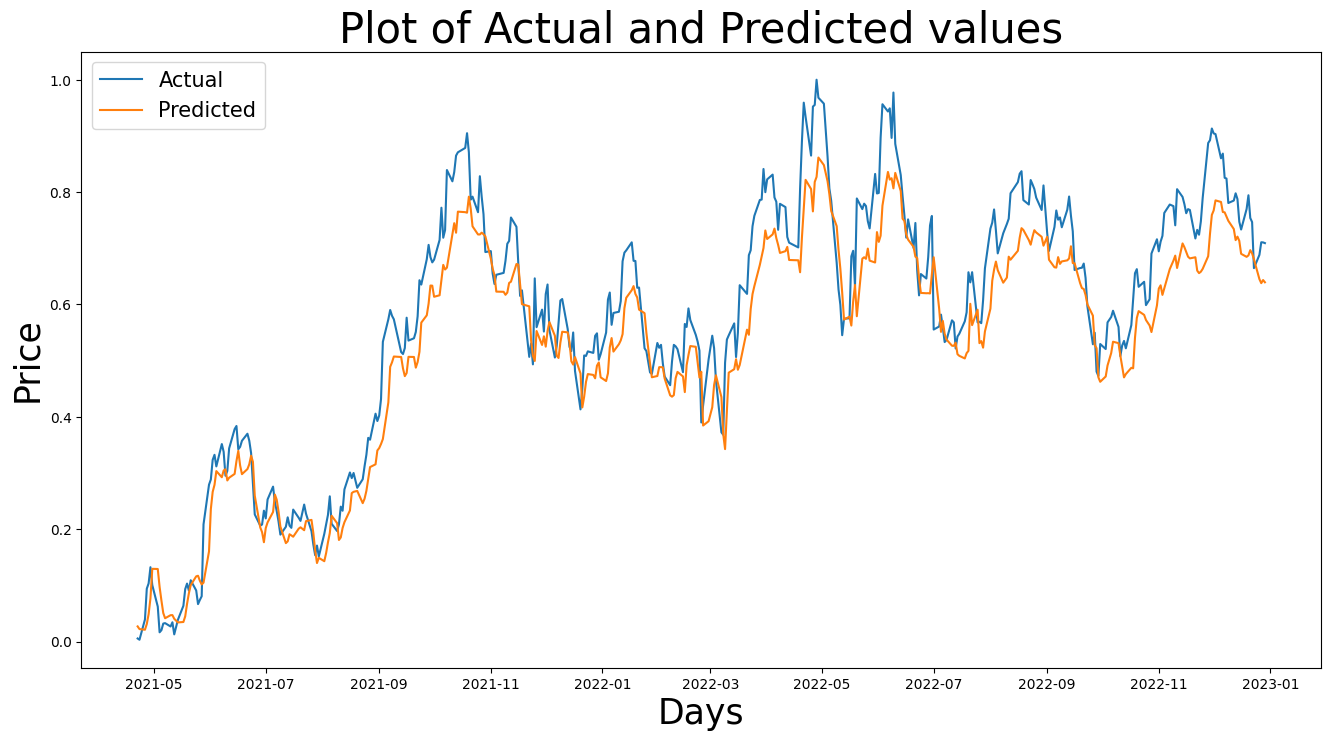

In [ ]:
ytestd['ytest'].plot()
ytestd['ypreds'].plot()
plt.title('Plot of Actual and Predicted values',fontsize=30)
plt.xlabel('Days',fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.legend(['Actual','Predicted'],fontsize=15)
plt.show()

# Conclusion

### As we can see from the graph the prediction both the model was able to predict the stock prices exactly the same. And also the adjusted r2 is approximately same indicating that addition of sentiment as one more independent variable does not improve the model any better. Therefore sentiment analysis as an additional factor is not required for stock price prediction.